In [1]:
using LinearAlgebra, JuMP, CPLEX, Plots

# Computing State-space Model from transfer function

$$ y(s) = \dfrac{1}{125s^3 + 75s^2 + 15s + 1} \ u(s) $$

State-space representation from the transfer function above (from matlab):

In [2]:
A = [2.45619225923395 -2.01096013810692 0.548811636094027; 
    1 0 0;
    0 1 0]
B = [0.0625; 0; 0]
C = [0.0183756999177941, 0.0633113580621751, 0.0136128264831647];

System configuration

In [3]:
# Sampling time
T = 1
# Simulation time in sampling periods
nsim = 75
# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1
# Number of states
nx = 3;

Controller configuration

In [4]:
# Output prediction horizon
p = 30
# Input control horizon 
m = 3
# Output weights
q = 1
# Input weights aggressive = 1 | detuned = 20
r = 20;

DRTO configuration

In [5]:
# Prediction horizon
pD = 50
# Input control horizon 
mD = 20;

Setting parameters for matrices for DRTO (Open and Closed-loop)

In [6]:
# setting initial values
x0 = [0;0;0]
y0 = C'*[0;0;0]
u0 = 0;

# setting bounds 
ΔUMax = 0.3
uMax = 1.2
uMin = 0.0
yMax = 1.5
yMin = 0.0;

# Solving OL-DRTO Problem

In [7]:
# Define our model
model = Model(CPLEX.Optimizer)
# set_optimizer_attribute(m, "warm_start_init_point", "yes")

# Set up variables
# inputs computed by MPCs
@variable(model, uMin <= u[1:pD] <= uMax)
# initial states used by MPC for computing the optimal trajectory
@variable(model, x[1:pD, 1:nx])
# setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
@variable(model, yMin <= y[1:pD] <= yMax)
# slacks for controlling setpoint into a zone
@variable(model, delta_y_p[1:pD] >= 0)
@variable(model, delta_y_m[1:pD] >= 0)

# Set up objective function
@objective(model, Min, sum(u[kk] + 1e5*(delta_y_p[kk]^2 + delta_y_m[kk]^2) for kk in 1:pD))

# Model Dynamic for Dynamic RTO
@constraint(model, OLDRTO_dyn_model_1, x[1,:] .== A*x0 + B*u0);
@constraint(model, OLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A*x[kk,:] + B*u[kk]);
@constraint(model, OLDRTO_model_out[kk=1:pD], y[kk] == C'*x[kk,:])

# fixing input after mD
@constraint(model, control_horizon[kk=(mD+1):pD], u[kk] == u[mD]);

# Δu constraints
@constraint(model, ΔU_max_0, -ΔUMax <= u[1] - u0 <= ΔUMax);
@constraint(model, ΔU[kk=2:mD], -ΔUMax <= u[kk] - u[kk - 1] <= ΔUMax);

# ysp in target
@constraint(model, target_plus[kk=1:pD], y[kk] + delta_y_p[kk] >= 0.95)
@constraint(model, target_minus[kk=1:pD], y[kk] - delta_y_m[kk] <= 1.05);

In [8]:
# Solve the model
solveOLDRTO = JuMP.optimize!
status = solveOLDRTO(model)
display(termination_status(model))
# #termination_status(model)
# #primal_status(m)

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 14 rows and 15 columns.
Aggregator did 134 substitutions.
Reduced QP has 202 rows, 221 columns, and 651 nonzeros.
Reduced QP objective Q matrix has 95 nonzeros.
Presolve time = 0.00 sec. (0.29 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 1075
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.07 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 202
  Integer space required    = 352
  Total non-zeros in factor = 1926
  Total FP ops to factor    = 31662
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   9.5706233e+06  -9.4944733e+06  6.56e+01  6.56e+01  1.90e+07
   1   3.6958179e+06  -3.4498080e+06  3.95e+01  3.95e+01  1.14e+07
   2   2.2398728e+06  -

OPTIMAL::TerminationStatusCode = 1

In [9]:
# Get values for plotting
xTraj = Matrix{Float64}(undef,nx,pD) # time series for plotting
uTraj = Matrix{Float64}(undef,pD,1) # time series for plotting
yTraj = Matrix{Float64}(undef,pD,1) # time series for plotting

# time series for plotting
ts = Vector{Float64}(undef,pD) 
for i in 1:pD
    ts[i] = 1*i
end

for i in 1:pD
    xTraj[:,i] .= JuMP.value.(x[i,:])
    yTraj[i] = JuMP.value.(y[i])
    uTraj[i] = JuMP.value.(u[i])
end;

#display(JuMP.value.(delta_y_m))
#display(JuMP.value.(delta_y_p))

# Solving CL-DRTO Problem

## Building matrices for MPC


Given the following discrete state-space model:

$ x(k+1) = A \ x(k) + b \ u(k) $ <br>
$ y(k) = C \ x(k)$ <br>

Using the supperposition property of linear systems, we obtain the model outputs from instants $k+1$ to $k+j$ as:
$ y(k + 1|k) = C \ x(k + 1|k) = CA \ x(k) + CB \ u(k|k)$ <br>
$ y(k + 2|k) = CA^2 \ x(k) + CAB \ u(k|k) + CB \ u(k+1|k)$ <br>
$ y(k + 3|k) = CA^3 \ x(k) + CA^2B \ u(k|k) + CAB \ u(k+1|k) + CB \ u(k+2|k)$ <br>
$ ... $ <br>
$ y(k + j|k) = CA^j \ x(k) + CA^{j-1}B \ u(k|k) + CA^{j-2}B \ u(k+1|k) + \cdots + CB \ u(k + j -1|k)$ 

Suppose now that:<br>
$ u(k + m|k) = u(k + m + 1|k) = \cdots = u(k + p - 1|k)$

The equations above (when $j > m$) can then be re-written as:
$ y(k + m + 1|k) = CA^{m+1} \ x(k) + CA^{m}B \ u(k|k) + CA^{m-1}B \ u(k+1|k) + \cdots + [CAB + CB] \ u(k + m -1|k)$ <br>
$ y(k + m + 2|k) = CA^{m+2} \ x(k) + CA^{m+1}B \ u(k|k) + CA^{m}B \ u(k+1|k) + \cdots + [CA^2B + CAB + CB] \ u(k + m -1|k)$ <br>
$ ... $ <br>
$ y(k + pk) = CA^{p} \ x(k) + CA^{p-1}B \ u(k|k) + CA^{p-2}B \ u(k+1|k) + \cdots + [CA^{p-m}B + CA^{p-m-1}B + \cdots + CB] \ u(k + m -1|k)$

Thus, the vector of output predictions can be written as follows:

$
\begin{vmatrix}
y(k + 1|k)\\
y(k + 2|k)\\
\vdots \\
y(k + m|k) \\
y(k + m + 1|k)\\ 
\vdots \\
y(k + p|k)
\end{vmatrix}
= 
\begin{vmatrix}
CA\\
CA^{2}\\
\vdots \\
CA^{m} \\
CA^{m+1}\\ 
\vdots \\
CA^{p}
\end{vmatrix} \ x(k)
+
\begin{vmatrix}
CB        & 0         & \cdots & 0\\
CAB       & CB        & \cdots & 0\\
\vdots    & \vdots    & \cdots & \vdots\\
CA^{m-1}B & CA^{m-2}B & \cdots & CB\\
CA^{m}B   & CA^{m-1}B & \cdots & C\tilde{A}_1B\\ 
\vdots    & \vdots    & \cdots & \vdots\\
CA^{p-1}B & CA^{p-2}B & \cdots & C\tilde{A}_{p-m}B
\end{vmatrix} 
\begin{vmatrix}
u(k|k)\\
u(k + 2|k)\\
\vdots \\
u(k + m - 1|k) 
\end{vmatrix}
$

where: <br>
$\tilde{A}_1 = A + I, \quad \tilde{A}_2 = A^2 + A + I, \quad \tilde{A}_{p-m} = A^{p-m} + A^{p-m-1} + \cdots + I$

Simpifying, we have: <br>
$ \bar{y}(k) = \Psi \ x(k) + \Theta \ u(k) $ 

In [10]:
Psi = C'*A
for ii in 2:p
    Psi = [Psi;  C'*A^ii]
end

# Computing Dynamic Matirx
a = [C'*A^(ii - 1)*B for ii in 1:p];
DynM = a

for ii in 1:(m - 2)
    a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
    DynM = [DynM  a]
end

# adjusting dynamic matrix for since p > m (last column)
b = C'*B

Ai = I(nx)
for ii = 1:(p - m)
    Ai = Ai + A^ii
    b = [b;C'*Ai*B]
end

Theta=[DynM [zeros(ny*(m-1),nu);b]];

The first term (output tracking) of the MPC objective function is: 

$ \sum_{j=1}^p (y(k + j|k) - y^{SP})^T \ Q \ (y(k + j|k) - y^{SP}) $

which can be written as:

$ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) $

where: 
$ \bar{Q} = diag\bigg( Q, \cdots, Q\bigg)$ - $p$ repetitions of $Q$

The second term (inputs movement penalization) of the MPC objective function is: 

$ \sum_{j=1}^{m-1} \Delta u(k + j|k)^T \ R \ \Delta u(k + j|k) $

We observe that:
$
\begin{vmatrix}
\Delta u(k|k)\\
\Delta u(k + 1|k)\\
\vdots \\
\Delta u(k + m - 1|k) 
\end{vmatrix}
= 
\begin{vmatrix}
u(k|k) - u(k - 1)\\
u(k + 1|k) - u(k|k)\\
\vdots \\
u(k + m - 1|k) - u(k + m - 2|k)
\end{vmatrix}
=
u_k - Mu_k - \bar{I} u(k - 1)
= (I_{nu,m} - M)u_k - \bar{I} u(k - 1)
= I_M u_k - \bar{I} u(k - 1)
$

in which:
$
M = 
\begin{vmatrix}
0_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
I_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
0_{nu} & I_{nu} & \cdots & 0_{nu} & 0_{nu}\\
\vdots & \vdots & \cdots & \vdots & \vdots\\
0_{nu} & 0_{nu} & \cdots & I_{nu} & 0_{nu}
\end{vmatrix}, \quad
\bar{I} = 
\begin{vmatrix}
I_{nu}\\
0_{nu}\\
0_{nu}\\
\vdots\\
0_{nu}
\end{vmatrix}
$

the second term can be written as:

$ (I_M u_k - \bar{I} u(k - 1))^T \ \bar{R} \ (I_M u_k - \bar{I} u(k - 1)) $

where: 
$ \bar{R} = diag\bigg( R, \cdots, R\bigg)$ - $m$ repetitions of $R$

In [11]:
# Creating Qbar and Rbar matrices
Qbar = Diagonal([q for ii in 1:p])
Rbar = Diagonal([r for ii in 1:m])

# Creating input movement OF penalty matrix 
M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
Ibar=[I(nu); zeros(nu*(m-1),nu)]
IM = I(nu*m) - M';

The objective function then can be reduced to a quadratic function of the form:
$$ J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

where:

$H = \Theta^T \ \bar{Q} \ \Theta + I_M^T \ \bar{R} \ I_M$ <br>
$c_f^T = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ \Theta + u(k-1)^T\bar{I}^T \ \bar{R} \ I_M$ <br>
$c = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) + u(k-1)^T\bar{I}^T \ \bar{R} \ \bar{I} \ u(k-1)$

In [12]:
# Matrix H
H = Theta'*Qbar*Theta+IM'*Rbar*IM;

## Testing MPC solution
the FOC of the unconstrained MPC problem is:

$$ \dfrac{\partial J_k}{\partial u_k}\bigg|_{u_k^\star} = 2 \ u_k^{\star,T} \ H + 2c_f^T = 0 $$ 
 
Hence: 

$$ \ u_k^{\star,T} \ H + c_f^T = 0 $$ 
$$ \ u_k^{\star,T} \ H = - c_f^T $$ 

Transposing both sides ($H$ is symmetric, $H^T = H$):

$$ H \ u_k^{\star} = - c_f $$ 

In [13]:
# assuming that ysp = 1 for the whole prediction horizon
ysp0 = ones(30,1)

cf_T = (Psi*x0 - ysp0)'*Qbar*Theta - u0'*Ibar'*Rbar*IM
size(cf_T')

# solving linear system
u0_LS = H\-cf_T'
#display(u0_LS)
size(u0_LS)
MPC_unc = Model(CPLEX.Optimizer)

# Set up variables
# inputs computed by MPCs
@variable(MPC_unc, uTest[1:2,1:3])
@expression(MPC_unc, cfT, (Psi*x0 - ysp0)'*Qbar*Theta - u0'*Ibar'*Rbar*IM)
@constraint(MPC_unc, MPC_sol[k=1:2], H*uTest[k,:] + cfT' .== 0)
@objective(MPC_unc, Min, 0) # searching for feasible point

JuMP.optimize!(MPC_unc)

#@show value.(uTest)

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
Tried aggregator 1 time.
Aggregator did 6 substitutions.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)
value.(uTest) = [0.31511541047156966 0.6015776278435494 0.861071766820799; 0.31511541047156955 0.6015776278435492 0.8610717668207988]


2×3 Matrix{Float64}:
 0.315115  0.601578  0.861072
 0.315115  0.601578  0.861072

Building the CL-DRTO problem

In [14]:
# Define our model
model_2 = Model(CPLEX.Optimizer)
# set_optimizer_attribute(m, "warm_start_init_point", "yes")

# Set up variables
# inputs computed by MPCs
@variable(model_2, uMin <= u[1:pD,1:m] <= uMax)
# initial states used by MPC for computing the optimal trajectory
@variable(model_2, x[1:pD, 1:nx])
# setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
@variable(model_2, yMin <= y[1:pD] <= yMax)
@variable(model_2, yMin <= ysp[1:pD] <= yMax)
# slacks for controlling setpoint into a zone
@variable(model_2, delta_y_p[1:pD] >= 0)
@variable(model_2, delta_y_m[1:pD] >= 0)

# Set up objective function
@objective(model_2, Min, sum(u[kk,1] + 1e5*(delta_y_p[kk]^2 + delta_y_m[kk]^2) for kk in 1:pD))

# Model Dynamic for Dynamic RTO
@constraint(model_2, CLDRTO_dyn_model_1, x[1,:] .== A*x0 + B*u0);
@constraint(model_2, CLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A*x[kk,:] + B*u[kk,1]);
@constraint(model_2, CLDRTO_model_out[kk=1:pD], y[kk] == C'*x[kk,:])

# Unconstrained MPC solution
@expression(model_2, cfT_1, (Psi*x[1,:] - ysp[1:p])'*Qbar*Theta - u0'*Ibar'*Rbar*IM)
@expression(model_2, cfT[kk=2:mD], (Psi*x[kk,:] - ysp[kk:(kk + p - 1)])'*Qbar*Theta - u[kk-1,1]'*Ibar'*Rbar*IM)

@constraint(model_2, MPC_sol_1, H*u[1,:] + cfT_1' .== 0)
@constraint(model_2, MPC_sol[kk=2:mD], H*u[kk,:] + cfT[kk]' .== 0)

# fixing input after mD
@constraint(model_2, control_horizon[kk=(mD+1):pD], u[kk] == u[mD]);

# Δu constraints
#@constraint(model_2, ΔU_max_0, -ΔUMax <= u[1] - u0 <= ΔUMax);
#@constraint(model_2, ΔU[kk=2:mD], -ΔUMax <= u[kk] - u[kk - 1] <= ΔUMax);

# ysp in target
@constraint(model_2, target_plus[kk=1:pD], y[kk] + delta_y_p[kk] >= 0.95)
@constraint(model_2, target_minus[kk=1:pD], y[kk] - delta_y_m[kk] <= 1.05);


In [15]:
# Solve the model
JuMP.optimize!(model_2)
display(termination_status(model_2))
# #termination_status(model_2)
# #primal_status(model_2)
# display(typeof(MOI.OPTIMAL))

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-26 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 11 rows and 72 columns.
Aggregator did 130 substitutions.
Reduced QP has 249 rows, 298 columns, and 2704 nonzeros.
Reduced QP objective Q matrix has 97 nonzeros.
Presolve time = 0.00 sec. (0.47 ticks)
Parallel mode: using up to 16 threads for barrier.
Number of nonzeros in lower triangle of A*A' = 3459
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.29 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 249
  Integer space required    = 547
  Total non-zeros in factor = 4765
  Total FP ops to factor    = 164685
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   9.7903000e+06  -9.7568528e+06  4.53e+02  1.69e+02  1.94e+07
   1   2.4086498e+06  -2.2980202e+06  2.19e+02  8.15e+01  9.37e+06
   2   2.4052362e+06 

OPTIMAL::TerminationStatusCode = 1

In [16]:
# Get values for plotting
xTraj_cl = Matrix{Float64}(undef,nx,pD) 
uTraj_cl = Matrix{Float64}(undef,pD,1) 
yspTraj_cl = Matrix{Float64}(undef,pD,1)
yTraj_cl = Matrix{Float64}(undef,pD,1)

for i in 1:pD
    xTraj_cl[:,i] .= JuMP.value.(x[i,:])
    yTraj_cl[i] = JuMP.value.(y[i])
    yspTraj_cl[i] = JuMP.value.(ysp[i])
    uTraj_cl[i] = JuMP.value.(u[i,1])
end;

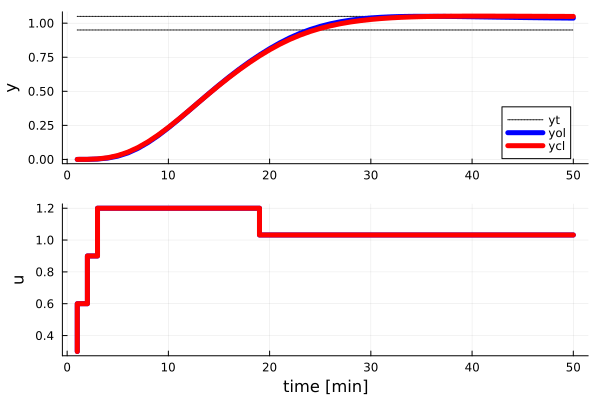

In [17]:
gr()

p1 = plot(ts,1.05*ones(length(ts)),linestyle = :dot,linecolor = :black)
p1 = plot!(ts,0.95*ones(length(ts)),linestyle = :dot,linecolor = :black)
p1 = plot!(ts,yTraj,linewidth=5,yaxis="y",linecolor = :blue)
p1 = plot!(ts,yTraj_cl,linewidth=5,linecolor = :red)
p1.series_list[1][:label] = "yt"
p1.series_list[2][:label] = ""
p1.series_list[3][:label] = "yol"
p1.series_list[4][:label] = "ycl"

p2 = plot(ts,uTraj,linewidth=5,xaxis="time [min]", yaxis="u",linecolor = :blue, linetype=:steppre,legend=false)
p2 = plot!(ts,uTraj,linewidth=5,xaxis="time [min]", yaxis="u",linecolor = :red, linetype=:steppre,legend=false)
g1 = plot(p1,p2,layout=(2,1))
display(g1)

# Simulating Plant Implementation of the Results

## Implementing open-loop DRTO

In [18]:
# time series for plotting
xPlant_ol = Matrix{Float64}(undef,nx,pD) 
uPlant_ol = Matrix{Float64}(undef,pD,1) 
yPlant_ol = Matrix{Float64}(undef,pD,1) 

# initializing simulation
xpk = x0
ypk = C'*x0
uk_1 = u0

for ii = 1:pD
    
    # updating arrays
    xPlant_ol[:,ii] = xpk
    uPlant_ol[ii] = ypk
    yPlant_ol[ii] = ypk
    
    # Preparing controller (only until mD)
    if ii <= mD
        # building terms of the OF that depend on current information
        yspk = yTraj[ii:(ii + p - 1)]
        
        # computing auxiliary term
        cf_T = (Psi*xpk - yspk)'*Qbar*Theta - uk_1'*Ibar'*Rbar*IM

        # solving linear system
        ukk = H\-cf_T'
        
        # extracting the first input
        uk = ukk[1]
    else # Otherwise, you simply do not update uk
        uk = uk_1
    end
    
    # applying input to the plant
    xpk = A*xpk + B*uk
    ypk = C'*xpk

        # loop
        uk_1 = uk

end

## Implementing closed-loop DRTO

In [19]:
# time series for plotting
xPlant_cl = Matrix{Float64}(undef,nx,pD) 
uPlant_cl = Matrix{Float64}(undef,pD,1) 
yPlant_cl = Matrix{Float64}(undef,pD,1) 

# initializing simulation
xpk = x0
ypk = C'*x0
uk_1 = u0

for ii = 1:pD
    
    # updating arrays
    xPlant_cl[:,ii] = xpk
    uPlant_cl[ii] = ypk
    yPlant_cl[ii] = ypk
    
    # Preparing controller (only until mD)
    if ii <= mD
        # building terms of the OF that depend on current information
        yspk = yspTraj_cl[ii:(ii + p - 1)]
        
        # computing auxiliary term
        cf_T = (Psi*xpk - yspk)'*Qbar*Theta - uk_1'*Ibar'*Rbar*IM

        # solving linear system
        ukk = H\-cf_T'
        
        # extracting the first input
        uk = ukk[1]
    else # Otherwise, you simply do not update uk
        uk = uk_1
    end

    # applying input to the plant
    xpk = A*xpk + B*uk
    ypk = C'*xpk

        # loop
        uk_1 = uk
end

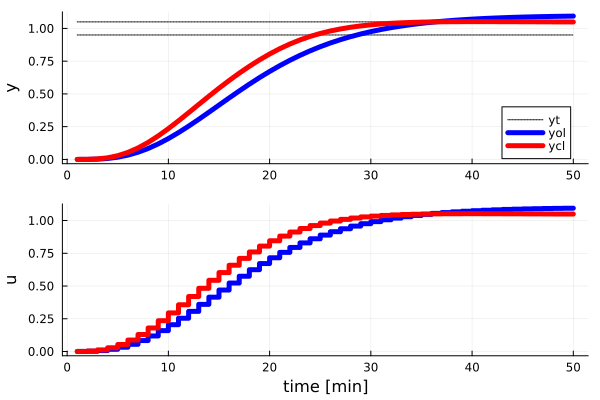

In [21]:
gr()

p1 = plot(ts,1.05*ones(length(ts)),linestyle = :dot,linecolor = :black)
p1 = plot!(ts,0.95*ones(length(ts)),linestyle = :dot,linecolor = :black)
p1 = plot!(ts,yPlant_ol,linewidth=5,yaxis="y",linecolor = :blue)
p1 = plot!(ts,yPlant_cl,linewidth=5,linecolor = :red)
p1.series_list[1][:label] = "yt"
p1.series_list[2][:label] = ""
p1.series_list[3][:label] = "yol"
p1.series_list[4][:label] = "ycl"

p2 = plot(ts,uPlant_ol,linewidth=5,xaxis="time [min]", yaxis="u",linecolor = :blue, linetype=:steppre,legend=false)
p2 = plot!(ts,uPlant_cl,linewidth=5,xaxis="time [min]", yaxis="u",linecolor = :red, linetype=:steppre,legend=false)
g1 = plot(p1,p2,layout=(2,1))
display(g1)

In [23]:
#display(yPlant_ol)
#display(yPlant_cl)

50×1 Matrix{Float64}:
 0.0
 0.000480373161591052
 0.003655283120734227
 0.012242951477703172
 0.02840234760490143
 0.05334340158125905
 0.08731983280906798
 0.12977768820746557
 0.1795366172079548
 0.2350593908948602
 0.29467715284723833
 0.3567477709506258
 0.4197608089547319
 ⋮
 1.0517668187272515
 1.0519281500913111
 1.051925614305285
 1.0518049258529643
 1.0516021317050737
 1.0513453382866764
 1.0510561800008607
 1.0507510571975773
 1.0504421715003278
 1.0501383852044561
 1.049845929535596
 1.0495689842521998